In [ ]:
# Spam Detection with Smooth Labeling + Data Augmentation (Colab-ready)

# =============================
# 1. Setup & Imports
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)





In [ ]:
# =============================
# 2. Data Loading & Analysis
# =============================
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["label", "text"])
display(df.head())


Saving SMSSpamCollection to SMSSpamCollection


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#Data Analysis
print(df.info(),'\n')
print(df.describe())
print(df.isnull().sum())
print(df['label'].value_counts())
spam_percentage = (df['label'] == 'spam').mean() * 100
print(f"Spam pcentage: {spam_percentage:.2f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None 

       label                    text
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30
label    0
text     0
dtype: int64
label
ham     4825
spam     747
Name: count, dtype: int64
Spam pcentage: 13.41%


In [ ]:
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# =============================
# 2. Data Loading & Cleaning
# =============================
nltk.download('stopwords')
nltk.download('wordnet')

URL_RE = re.compile(
    r"""(
    (?:h[tＴ][tＴ][pＰsＳ]?    # http / https with homoglyphs
    |hxxp                      # obfuscated protocol
    |www)                      # www start
    [\s:/]*                    # allow obfuscation spaces, colons, slashes
    (?:\[?\.\]?|\(dot\)|-dot-|\.|\s*\.\s*)*  # dot obfuscations
    [a-z0-9\-]+                # domain part
    (?:\.(?:[a-z]{2,}|[a-z]{2,}\.[a-z]{2,}))+ # tld
    (?:[/?#][^\s]*)?           # optional path/query
    |                           # OR standard clean URLs
    (?:http|https|ftp|file)s?://\S+|www\.\S+
    )""",
    re.IGNORECASE | re.VERBOSE
)

EMAIL_RE = re.compile(
    r"""
    [a-z0-9._%+-]+             # username
    (?:@|\s*\[at\]\s*|\s*\(at\)\s*)  # @ or obfuscated versions
    [a-z0-9.-]+                # domain
    (?:\.(?:[a-z]{2,}|[a-z]{2,}\.[a-z]{2,}))  # TLD
    """,
    re.IGNORECASE | re.VERBOSE
)
#PHONE_RE = re.compile(r'(?:(?:\+|0{0,2})[1-9]\d{0,2}[\s.-]?)?(?:\(?\d{3}\)?[\s.-]?)?\d{3}[\s.-]?\d{4,9}')
PHONE_RE = re.compile(
    r"""
    # Optional country code: +91, 001, 0, etc.
    (?:\+?\d{1,3}[\s.-]?)?

    # Optional area code: (123), 123
    (?:\(?\d{2,5}\)?[\s.-]?)?

    # Main number: allow 2–4 digits blocks separated by space/dot/dash
    (?:\d{2,4}[\s.-]?){2,5}\d{2,4}
    """,
    re.VERBOSE
)

STOPWORDS = set(stopwords.words('english'))
IMPORTANT_WORDS = {'free', 'win', 'claim', 'urgent', 'prize', 'txt', 'csh',"no", "not", "free", "call","won"}
CUSTOM_STOPWORDS = STOPWORDS - IMPORTANT_WORDS

lemmatizer = WordNetLemmatizer()

def preprocess(s: str) -> str:
    s = str(s)

    # Replace sensitive patterns with placeholders
    s = URL_RE.sub(' <URL> ', s)
    s = EMAIL_RE.sub(' <EMAIL> ', s)
    s = PHONE_RE.sub(' <PHONE> ', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[^\w\s<>]', ' ', s)
    s = s.strip().lower()
    s = re.sub(r'\b\d+\b', ' ', s)
    s = re.sub(r'\b(?=\w*\d)(?=\w*[a-z])[a-z0-9]{10,}\b', '<ALPHANUM>', s)
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    s = re.sub(r'\s+', ' ', s).strip()

    tokens = s.split()
    tokens = [word for word in tokens if word not in CUSTOM_STOPWORDS]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['text_clean'] = df['text'].apply(preprocess)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,label,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts 21s...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [ ]:
# =============================
# 3. Data Augmentation - not execute
# =============================
def augment_text(text):
    aug_variants = []
    if "win" in text:
        aug_variants.append(text.replace("win", "claim now"))
    if "free" in text:
        aug_variants.append(text.replace("free", "complimentary"))
    if "offer" in text:
        aug_variants.append(text.replace("offer", "deal"))
    if random.random() > 0.5:
        aug_variants.append(text.replace(" ", ""))
    return list(set(aug_variants))

augmented_rows = []
for _, row in df[df["label"] == 1].iterrows():
    for aug in augment_text(row["text"]):
        augmented_rows.append({"text": aug, "label": 1})

df_aug = pd.DataFrame(augmented_rows)
df_full = pd.concat([df, df_aug]).reset_index(drop=True)

In [ ]:
print("Before cleaning:",df['text'].duplicated().sum())
print("After cleaning:",df['text_clean'].duplicated().sum())

df = df.drop_duplicates(subset='text_clean', keep='first')
df = df.reset_index(drop=True)
print("After removing:",df['text_clean'].duplicated().sum())
df.head()


Before cleaning: 403
After cleaning: 497
After removing: 0


,label,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts 21s...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [ ]:
df.info()
spam_percentage = (df['label'] == 1).mean() * 100
print(f"Spam pcentage: {spam_percentage:.2f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5075 entries, 0 to 5074
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5075 non-null   int64 
 1   text        5075 non-null   object
 2   text_clean  5075 non-null   object
dtypes: int64(1), object(2)
memory usage: 119.1+ KB
Spam pcentage: 11.72%


In [ ]:
# =============================
# 5.Slpitting
# =============================
X = df['text_clean'].values
y = df['label'].values
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=SEED
)

val_size = 0.15 / (1 - 0.15)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=SEED
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))



Train size: 3551
Validation size: 762
Test size: 762


In [ ]:
# Analyse number of tokens
message_lengths = [len(x.split()) for x in X_train]
print("Max Message Length:",max(message_lengths))
print("Min Message Length:",min(message_lengths))
print("Avg Message Length:",np.mean(message_lengths))
print("50th percentile (median):", np.percentile(message_lengths, 50))
print("75th percentile:", np.percentile(message_lengths, 75))
print("90th percentile:", np.percentile(message_lengths, 90))
print("95th percentile:", np.percentile(message_lengths, 95))
print("99th percentile:", np.percentile(message_lengths, 99))



Max Message Length: 79
Min Message Length: 1
Avg Message Length: 9.087580963108984
50th percentile (median): 7.0
75th percentile: 13.0
90th percentile: 18.0
95th percentile: 21.0
99th percentile: 29.0


In [ ]:
# =============================
# 5. Tokenization & Padding
# =============================
MAX_LEN = 100
MAX_VOCAB = 7000
EMB_DIM = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print("Word Index size:", len(word_index))


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Example padded sequence:", X_train_pad[0])


# Apply smooth labels
#y_train_smooth = smooth_labels(y_train.astype(np.float32), 0.1)

Word Index size: 6044
Example padded sequence: [2644   97   13  235  167 2645    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
# Save the tokenizer configuration to a JSON file
import json
tokenizer_json = tokenizer.to_json()
with open('final_tokenizer_2.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

print("Final Tokenizer saved to final_tokenizer_2.json")

Final Tokenizer saved to final_tokenizer_2.json


In [ ]:
# =============================
# 6. Model (BiLSTM)
# =============================
LSTM_UNITS = 64
DROPOUT = 0.5
DENSE_UNITS = 64
def build_bilstm(vocab_size, embedding_dim, maxlen):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=EMB_DIM, input_length=maxlen, mask_zero=True),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),   # keep sequences
        Dropout(DROPOUT),
        Bidirectional(LSTM(LSTM_UNITS//2)),  # stacked second BiLSTM
        Dropout(DROPOUT),
        Dense(DENSE_UNITS, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

bilstm_model = build_bilstm(7000,100,100)
bilstm_model.build(input_shape=(None, 30))
bilstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 30, 100)        │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 30, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 829,921 (3.17 MB)

 Trainable params: 829,921 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)  # [0,1]
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {0: weights[0], 1: weights[1]}

print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.5665283982131462), 1: np.float64(4.257793764988009)}


In [ ]:
# =============================
# 7. Traning Model (BiLSTM)
# =============================
LSTM_UNITS = 64
DROPOUT = 0.5
DENSE_UNITS = 32
BATCH_SIZE = 64
EPOCHS = 20

def model_train(model, X_train_pad, y_train, X_val_pad, y_val):
      early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
      reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6,verbose=1)
      model_checkpoint = ModelCheckpoint('final_model_2.h5', monitor='val_loss', save_best_only=True)
      history = model.fit(
          X_train_pad, y_train,
          validation_data=(X_val_pad, y_val),
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          class_weight={0: 0.567, 1: 4.258},
          callbacks=[early_stopping, reduce_lr, model_checkpoint]
      )
      return history

history = model_train(bilstm_model, X_train_pad, y_train, X_val_pad, y_val)


model = bilstm_model

# === Evaluate ===
val_loss, val_acc = model.evaluate(X_val_pad, y_val)
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")



Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8031 - loss: 0.5883

56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 449ms/step - accuracy: 0.8039 - loss: 0.5854 - val_accuracy: 0.9764 - val_loss: 0.1280 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9811 - loss: 0.1370

56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 400ms/step - accuracy: 0.9812 - loss: 0.1362 - val_accuracy: 0.9803 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9942 - loss: 0.0318

56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.9942 - loss: 0.0316 - val_accuracy: 0.9829 - val_loss: 0.0684 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9965 - loss: 0.0125

56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - accuracy: 0.9965 - loss: 0.0124 - val_accuracy: 0.9869 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 400ms/step - accuracy: 0.9973 - loss: 0.0110 - val_accuracy: 0.9777 - val_loss: 0.0938 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9928 - loss: 0.0116
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - accuracy: 0.9929 - loss: 0.0115 - val_accuracy: 0.9777 - val_loss: 0.1032 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - accuracy: 0.9989 - loss: 0.0040 - val_accuracy: 0.9790 - val_loss: 0.0991 - learning_rate: 5.0000e-04
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9786 - loss: 0.0883
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9923 - loss: 0.0638
Validation Accuracy: 0.9869
Test Accuracy: 0.9882


In [ ]:
# =============================
# 7. Evaluation Functions
# =============================

def plot_training_history(history):
    """Plots the training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def evaluate_datasets(model, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test):
    print("--- Evaluation on Train Set ---")
    train_loss, train_acc = model.evaluate(X_train_pad, y_train, verbose=0)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    print("\n--- Evaluation on Validation Set ---")
    val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    print("\n--- Evaluation on Test Set ---")
    test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

def display_classification_report_and_confusion_matrix(y_true, y_pred):
    """Displays the classification report and confusion matrix."""
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred))

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham (0)', 'Spam (1)'], yticklabels=['Ham (0)', 'Spam (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    """Plots the ROC curve and displays the AUC."""
    print("\n--- ROC Curve ---")
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print(f"ROC-AUC: {roc_auc:.4f}")

def plot_precision_recall_curve(y_true, y_pred_prob):
    """Plots the Precision-Recall curve and displays the AUC."""
    print("\n--- Precision-Recall Curve ---")
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

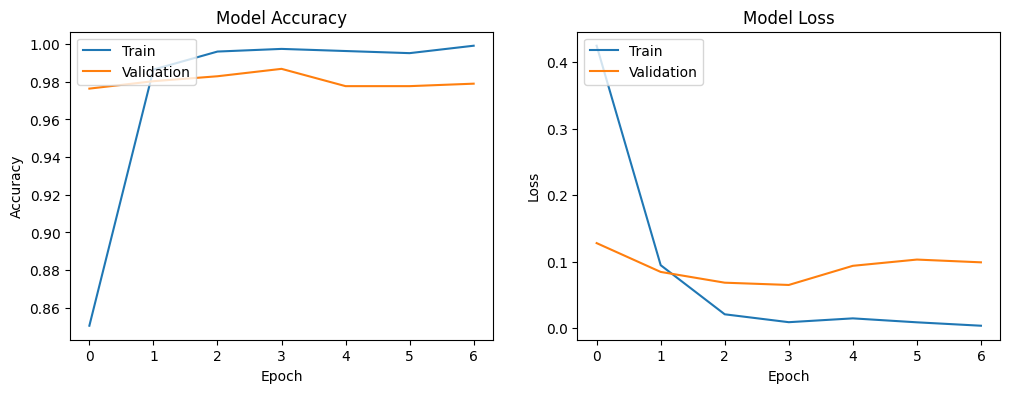

--- Evaluation on Train Set ---
Train Loss: 0.0059, Train Accuracy: 0.9986

--- Evaluation on Validation Set ---
Validation Loss: 0.0650, Validation Accuracy: 0.9869

--- Evaluation on Test Set ---
Test Loss: 0.0861, Test Accuracy: 0.9882
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       673
           1       0.97      0.93      0.95        89

    accuracy                           0.99       762
   macro avg       0.98      0.96      0.97       762
weighted avg       0.99      0.99      0.99       762


--- Confusion Matrix ---


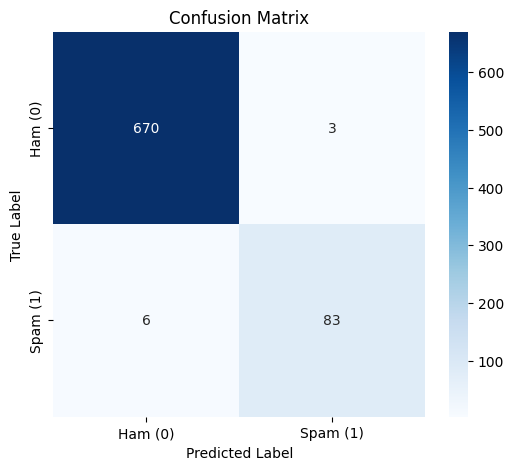


--- ROC Curve ---


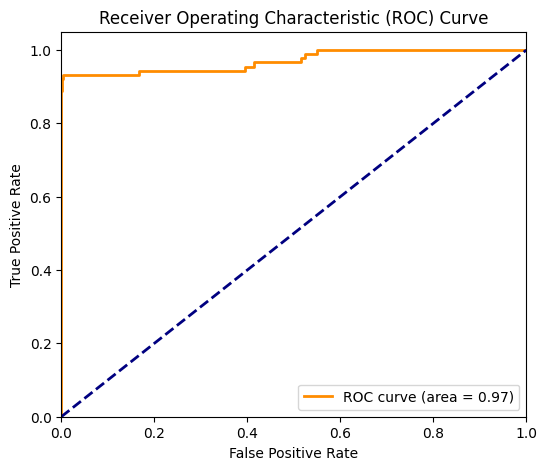

ROC-AUC: 0.9711

--- Precision-Recall Curve ---


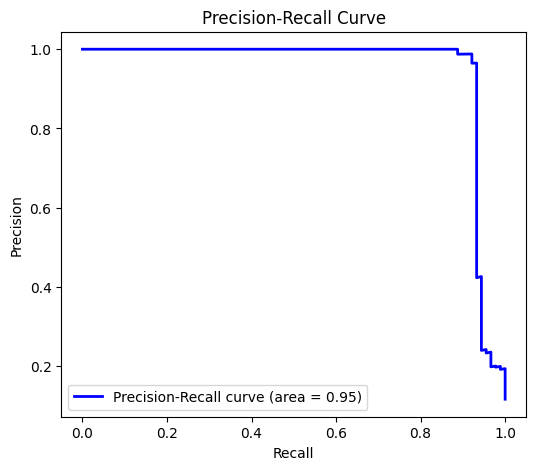

Precision-Recall AUC: 0.9485


In [ ]:
# Call the evaluation functions with your data and model
plot_training_history(history)
evaluate_datasets(model, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

# Get predictions for classification report, confusion matrix, and curves
y_test_pred_prob = model.predict(X_test_pad).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

display_classification_report_and_confusion_matrix(y_test, y_test_pred)
plot_roc_curve(y_test, y_test_pred_prob)
plot_precision_recall_curve(y_test, y_test_pred_prob)

In [ ]:
# =============================
# 8. Prediction Function with Smooth Interpretation
# =============================


URL_RE = re.compile(
    r"""(
    (?:h[tＴ][tＴ][pＰsＳ]?    # http / https with homoglyphs
    |hxxp                      # obfuscated protocol
    |www)                      # www start
    [\s:/]*                    # allow obfuscation spaces, colons, slashes
    (?:\[?\.\]?|\(dot\)|-dot-|\.|\s*\.\s*)*  # dot obfuscations
    [a-z0-9\-]+                # domain part
    (?:\.(?:[a-z]{2,}|[a-z]{2,}\.[a-z]{2,}))+ # tld
    (?:[/?#][^\s]*)?           # optional path/query
    |                           # OR standard clean URLs
    (?:http|https|ftp|file)s?://\S+|www\.\S+
    )""",
    re.IGNORECASE | re.VERBOSE
)

EMAIL_RE = re.compile(
    r"""
    [a-z0-9._%+-]+             # username
    (?:@|\s*\[at\]\s*|\s*\(at\)\s*)  # @ or obfuscated versions
    [a-z0-9.-]+                # domain
    (?:\.(?:[a-z]{2,}|[a-z]{2,}\.[a-z]{2,}))  # TLD
    """,
    re.IGNORECASE | re.VERBOSE
)
#PHONE_RE = re.compile(r'(?:(?:\+|0{0,2})[1-9]\d{0,2}[\s.-]?)?(?:\(?\d{3}\)?[\s.-]?)?\d{3}[\s.-]?\d{4,9}')
PHONE_RE = re.compile(
    r"""
    # Optional country code: +91, 001, 0, etc.
    (?:\+?\d{1,3}[\s.-]?)?

    # Optional area code: (123), 123
    (?:\(?\d{2,5}\)?[\s.-]?)?

    # Main number: allow 2–4 digits blocks separated by space/dot/dash
    (?:\d{2,4}[\s.-]?){2,5}\d{2,4}
    """,
    re.VERBOSE
)

STOPWORDS = set(stopwords.words('english'))
IMPORTANT_WORDS = {'free', 'win', 'claim', 'urgent', 'prize', 'txt', 'csh',"no", "not", "free", "call","won"}
CUSTOM_STOPWORDS = STOPWORDS - IMPORTANT_WORDS

lemmatizer = WordNetLemmatizer()

def clean_text(s: str) -> str:
    s = str(s)

    # Replace sensitive patterns with placeholders
    s = URL_RE.sub(' <URL> ', s)
    s = EMAIL_RE.sub(' <EMAIL> ', s)
    s = PHONE_RE.sub(' <PHONE> ', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[^\w\s<>]', ' ', s)
    s = s.strip().lower()
    s = re.sub(r'\b\d+\b', ' ', s)
    s = re.sub(r'\b(?=\w*\d)(?=\w*[a-z])[a-z0-9]{10,}\b', '<ALPHANUM>', s)
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    s = re.sub(r'\s+', ' ', s).strip()

    tokens = s.split()
    tokens = [word for word in tokens if word not in CUSTOM_STOPWORDS]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)




def predict_message_smooth(msg, model, tokenizer, threshold=0.5):
    """
    Predicts the spam probability of a message and provides a smooth interpretation
    and a binary label based on a threshold.
    """

    cleaned_msg = clean_text(msg)
    seq = loaded_tokenizer.texts_to_sequences([cleaned_msg])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    prob = model.predict(padded)[0][0]

    # Determine binary label based on threshold
    binary_label = 'spam' if prob >= threshold else 'not spam'

    # Smooth interpretation based on probability
    if prob >= 0.8:
        interpretation = "Highly likely to be spam."
    elif prob >= 0.6:
        interpretation = "Likely to be spam."
    elif prob >= 0.4:
        interpretation = "Possibly spam, or needs review."
    elif prob >= 0.2:
        interpretation = "Likely to be ham (not spam)."
    else:
        interpretation = "Highly likely to be ham (not spam)."


    return {
        "message": msg,
        #"cleaned_message": cleaned_msg,
        "spam_probability": float(prob),
        "predicted_label": binary_label, # Added binary label
        #"interpretation": interpretation
    }



## 8. Load Model and Tokenizer for Prediction

In [ ]:
# =============================
# 9. Prediction Examples
# =============================

# Ensure model and tokenizer were loaded successfully before proceeding
from tensorflow.keras.models import load_model
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json

loaded_model = load_model('final_model_2.h5')
with open('final_tokenizer_2.json', 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)
loaded_tokenizer = tokenizer_from_json(tokenizer_json)
print("Tokenizer loaded successfully.")
if loaded_model is not None and loaded_tokenizer is not None:
    # Example messages as a list
    messages_to_predict = [
        "Congratulations! You've won a FREE prize! Click here to claim now: https://leetcode.com/problems/",
        "Hey, just wanted to check in and see how you're doing.",
        "Urgent: Your account has been compromised. Reply with your password to secure it.",
        "Meeting scheduled for tomorrow at 10 AM.",
        "Free entry into our weekly draw! Reply YES to opt-in.",
        "Can we reschedule our call to next week?"
    ]

    print("--- Predictions ---")
    for msg in messages_to_predict:
        prediction_result = predict_message_smooth(msg, loaded_model, loaded_tokenizer)
        print(prediction_result)
        print("-" * 20) # Separator for clarity

else:
    print("Model or Tokenizer not loaded. Cannot run prediction examples.")

Tokenizer loaded successfully.
--- Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
{'message': "Congratulations! You've won a FREE prize! Click here to claim now: https://leetcode.com/problems/", 'spam_probability': 0.9998855590820312, 'predicted_label': 'spam'}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
{'message': "Hey, just wanted to check in and see how you're doing.", 'spam_probability': 0.0003873812092933804, 'predicted_label': 'not spam'}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
{'message': 'Urgent: Your account has been compromised. Reply with your password to secure it.', 'spam_probability': 0.0330071747303009, 'predicted_label': 'not spam'}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
{'message': 'Meeting scheduled for tomorrow at 10 AM.', 'spam_probability': 0.0038914773613214493, 'predicted_label': 'not spam'}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
{'message': 'Free entry into our weekly draw! Reply YE

In [ ]:
    messages_to_predict = [
        "Special pr0m0tion: shoes with up to 90% discount.✨",
        "Special promotion: shoes with up to 90% discount.",
        "Your number was picked for a reward worth $250! Claim now.🏆	",
        "Unusual l0gin attempts notic3d. re@ctivate AS@P.	",
        "Unsual login attempts noticed. reactivate ASAP",
        "Notice! verify your bank d3tails n0w to avoid interruption.",
        "Exclusive dating site invitation 💌. Sign up: bit.ly/love123 💋",
        "Can we reschedule our call to next week?",
        "Congratulations! 🎉 You have won $1000 gift card. Claim now: bit.ly/win1000 🎉",
        "You are the lucky winner! 🏆 Click to collect: claimprize.live",
        "Scratch & Win exciting prizes! 🎰 Play now at lottofast.com 🔥",
        "Special lottery result ✅ You won! Check: freerewards.co",
        "Y0u are the lucky winner! 🏆 Click t0 c0llect: l0tt0fast.c0m",
        "Scratch & Win exciting prizes! 🎰 Play n0w at claimprize.live",
        "Claim your $500 Amazon voucher 🎁 today: freerewards.co",
        "Special lottery result ✅ You won! Check: bit.ly/win1000 🎉",
        "Special lottery result, you won! Check: bit.ly/win1000",
        "You are the lucky winner! 🏆 Click to collect: lottofast.com 🎉",
        "Get a brand new iPh0ne 15 📱 f0r just $1. Hurry: freerewards.c0"

    ]

    print("--- Predictions ---")
    for msg in messages_to_predict:
        prediction_result = predict_message_smooth(msg, loaded_model, loaded_tokenizer)
        print(prediction_result)
        print("-" * 20) # Separator for clarity

--- Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
{'message': 'Special pr0m0tion: shoes with up to 90% discount.✨', 'spam_probability': 0.2171027511358261, 'predicted_label': 'not spam'}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
{'message': 'Special promotion: shoes with up to 90% discount.', 'spam_probability': 0.2171027511358261, 'predicted_label': 'not spam'}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
{'message': 'Your number was picked for a reward worth $250! Claim now.🏆\t', 'spam_probability': 0.9011437296867371, 'predicted_label': 'spam'}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
{'message': 'Unusual l0gin attempts notic3d. re@ctivate AS@P.\t', 'spam_probability': 0.7655900120735168, 'predicted_label': 'spam'}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
{'message': 'Unsual login attempts noticed. reactivate ASAP', 'spam_probability': 0.8999131917953491, 'predicted_label': 'spam'}
--------------------
1/1 ━━